In [3]:
import numpy as np # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
fs = 256
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
from CogBeacon_PlotUtils import *
from CogBeaconDataset import CogBeaconDataset

cogbeacon_root_path = '/Users/athenasaghi/VSProjects/CognitiveFatigueDetection/CogFatigueData/CogBeacon/'
dataset = CogBeaconDataset(cogbeacon_root_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def groupByfatigueLevel(data, labels):
    grouped_data = defaultdict(list)
    for index, label in enumerate(labels):
        grouped_data[label].append(data[index])
    return grouped_data
           
def loadData(user_id = [1], session_day = ['First'], game_mode=['m'] , channel = "AF7"):
    # user_id = [str(i) for i in range(20) if i not in (8, 18)] 
    eegData=[]
    fatigueLabels = []
    for session in session_day:
        for user in user_id:
            for mode in game_mode:
                participant_data_per_turn , participant_labels = dataset.load_session_by_participant(user, session,mode,channel)
                eegData.append(participant_data_per_turn)
            fatigueLabels.append(participant_labels)
    return  eegData , fatigueLabels 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
eegData , fatigueLabels = loadData(user_id=[1],channel="AF8",game_mode='m')


session loaded successfully {'user_id': '1', 'stimuli_type': 'v', 'game_mode': 'm', 'session_day': 'First', 'wcst_version': 'V1'} size of the session data 120


In [100]:
def plot_Sq(self, filename=None, ignore_q0=True, figsize=(6, 4), plot_CI=True):
    """
    Plots all structure functions on one plot (S vs. scale) with different q-values as individual lines.
    """
    if self.n_rep > 1:
        raise ValueError('Cannot plot structure functions for more than 1 repetition at a time')

    # Initialize the figure with smaller size
    fig, ax = plt.subplots(figsize=figsize)

    if ignore_q0:
        q_values = [q for q in self.q if q != 0.0]
    else:
        q_values = self.q

    # Light purple hex color
    light_purple = "#DDA0DD"

    # Loop through q-values and plot S(j, q) vs scale with smaller markers and lines
    for q in q_values:
        y = self.S_q(q)[:, 0]  # Get S values (first column: mean values)
        x = self.j  # Scale (j)

        ax.scatter(x, y, color=light_purple, alpha=0.7, s=10)  # `s` adjusts marker size

        coefficients = np.polyfit(np.log2(x), np.log(y), 1)
        linear_fit = np.polyval(coefficients, np.log2(x))
        ax.plot(x, np.exp(linear_fit), color=light_purple, linestyle='--', alpha=0.9)

    # Set plot labels
    ax.set_xscale("log",base = 2)  
    # ax.set_yscale("log")  
    # ax.set_xscale("linear")  
    # ax.set_yscale("linear") 


    ax.set_xlabel("Scale (segment sample sizes)", fontsize=10)
    ax.set_ylabel("$S_F(q)$", fontsize=10)

    

    # Save or show the figure
    if filename:
        plt.savefig(filename, dpi=300)  # Increase DPI for better quality in smaller plots
    else:
        plt.show()


In [105]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qs_together(data_obj, figlabel='Structure Functions', filename=None,
                     ignore_q0=True, figsize=(8, 6), plot_scales=None,
                     plot_CI=True, scaling_range=0):
    """
    Plots all structure functions for different q-values on a single plot.
    """

    if data_obj.n_rep > 1:
        raise ValueError('Cannot plot structure functions for more than '
                         '1 repetition at a time')

    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(data_obj.formalism + r' - structure functions $\log_2(S(j,q))$')

    if plot_scales is None:
        idx = np.s_[:]
    else:
        j_min = data_obj.j.min()
        idx = np.s_[plot_scales[0] - j_min:plot_scales[1] - j_min + 1]

    x = data_obj.j[idx]
    light_purple = "#DDA0DD"

    for ind_q, q in enumerate(data_obj.q):
        if q == 0.0 and ignore_q0:
            continue

        y = data_obj.S_q(q)[idx]

        if data_obj.bootstrapped_mrq is not None and plot_CI:
            CI = data_obj.CIE_S_q(q)[idx]
            CI -= y
            CI[:, 1] *= -1
            assert (CI < 0).sum() == 0
            CI = CI.transpose()
        else:
            CI = None

        # Plot each q with error bars
        ax.scatter(x, y[:, 0], color=light_purple, alpha=0.9, s=10)
        coefficients = np.polyfit(np.log2(x), np.log(y[:, 0]), 1)
        linear_fit = np.polyval(coefficients, np.log2(x))
        ax.plot(x, np.exp(linear_fit), color=light_purple, linestyle='--', alpha=0.9)


        # # Add scaling line if zeta is available
        # if len(data_obj.zeta) > 0:
        #     x0, x1 = data_obj.scaling_ranges[scaling_range]
        #     slope = data_obj.zeta[ind_q, scaling_range, 0]
        #     intercept = data_obj.intercept[ind_q, scaling_range, 0]

        #     assert x0 in x, "Scaling range not included in plotting range"
        #     assert x1 in x, "Scaling range not included in plotting range"

        #     y0 = slope * x0 + intercept
        #     y1 = slope * x1 + intercept

        #     ax.plot([x0, x1], [y0, y1], color=light_purple ,
        #             linestyle='-', linewidth=2, label=f'Scaling: q={q:.3f}')

    # Add labels and legend
    ax.set_xlabel('j (scale)')
    ax.set_ylabel(r'$\log_2(S(j,q))$')
    # ax.legend(title='q-values', loc='best', fontsize='small')
    # ax.grid(True)

    # plt.tight_layout()

    # Save or show the figure
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()


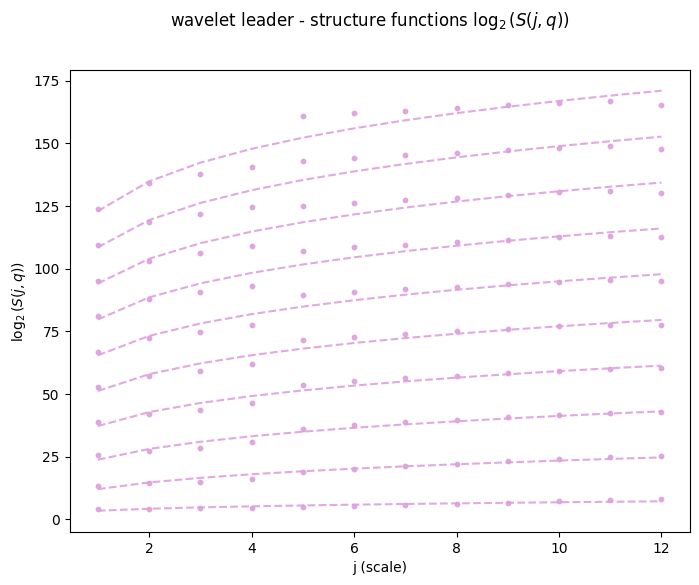

In [106]:


for signal in eegData:
    dwt, lwt = mfa.mf_analysis_full(np.concatenate(signal),
    scaling_ranges=[[1,12]],
    # q = build_q_log(1,20,10),
    # q=[2,4,8,16,32,64,128,256,1024,2048],
    q =list(range(1,20,2)),
    n_cumul=2,
    p_exp=np.inf,
    gamint=0,
    weighted=None)
    st, cumul, spectrum, hmin = lwt
    # plot_Sq(st)
    plot_qs_together(st)



In [145]:
def plot_average_S_q(self_list, filename=None, ignore_q0=True, figsize=(6, 4)):
    """
    Plots the average S_q values across a list of self inputs.
    The average is computed across the second dimension of S_q for all q-values
    and represented as a 1D list for each q.
    """
    # Initialize the figure
    fig, ax = plt.subplots(figsize=figsize)

    # Use a consistent purple color scheme
    dark_purple = '#4B0082'  # Dark purple for the average plot

    # Extract q_values and initialize container for S_q averages
    q_values = self_list[0].q if not ignore_q0 else [q for q in self_list[0].q if q != 0.0]
    x = self_list[0].j  # Assumes all self objects have the same j values

    # Loop through q-values and calculate the average across self_list
    for i, q in enumerate(q_values):
        # Collect S_q values for the current q across all self inputs
        S_q_values = [self.S_q(q)[:, 0] for self in self_list]  # Shape: (num_selfs, len(x))
        stacked = np.stack(S_q_values, axis=0)  # Stack into a 2D array: (num_selfs, len(x))
        averaged_S_q_1d = np.mean(stacked, axis=0)  # Average along the first axis

        # Plot the averaged S_q values
        log_x = np.log2(x)
        log_y = np.log(averaged_S_q_1d)

        # Perform a linear fit for the averaged data
        fit_coeffs = np.polyfit(log_x, log_y, 1)
        fit_y = np.exp(np.polyval(fit_coeffs, log_x))

        # Plot the average S_q values with a linear fit
        ax.scatter(x, averaged_S_q_1d, color=dark_purple, s=20, label=f"q={q:.2f}")
        ax.plot(x, fit_y, color=dark_purple, linewidth=2, linestyle='--', alpha=0.8)

    # Set log scale for x-axis and linear scale for y-axis
    ax.set_xscale("log", base=2)  # Log scale for x-axis
    ax.set_xlabel("scale (segment sample sizes)", fontsize=10)
    ax.set_ylabel("$S_F(q)$ (Average)", fontsize=10)

    # Add a minimalistic title
    ax.set_title("Average S_q Across Inputs", fontsize=12, fontweight='bold')

    # Customize ticks for clarity
    ax.tick_params(axis='both', which='both', direction='in', length=4, labelsize=8)

    # Add gridlines with default styling
    ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add legend
    # ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()

    # Save or show the figure
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()


In [292]:
# S_lists = []
# for signal in eegData:
#     dwt, lwt = mfa.mf_analysis_full(np.concatenate(signal),
#     scaling_ranges=[[1,12]],
#     q = build_q_log(1,10,10),
#     # q=[2,4,8,16,32,64,128],
#     # q =list(range(-10,10)),
#     n_cumul=2,
#     p_exp=np.inf,
#     gamint=0,
#     weighted=None)
#     structure, cumul, spectrum, hmin = lwt
#     S_lists.append(structure)

# plot_average_S_q(S_lists)

new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)
new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)
new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)
new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)
new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)
new scaling range is [[ 1 10]] 10
new scaling range is [[ 1 10]] 10
(8, 1, 1)


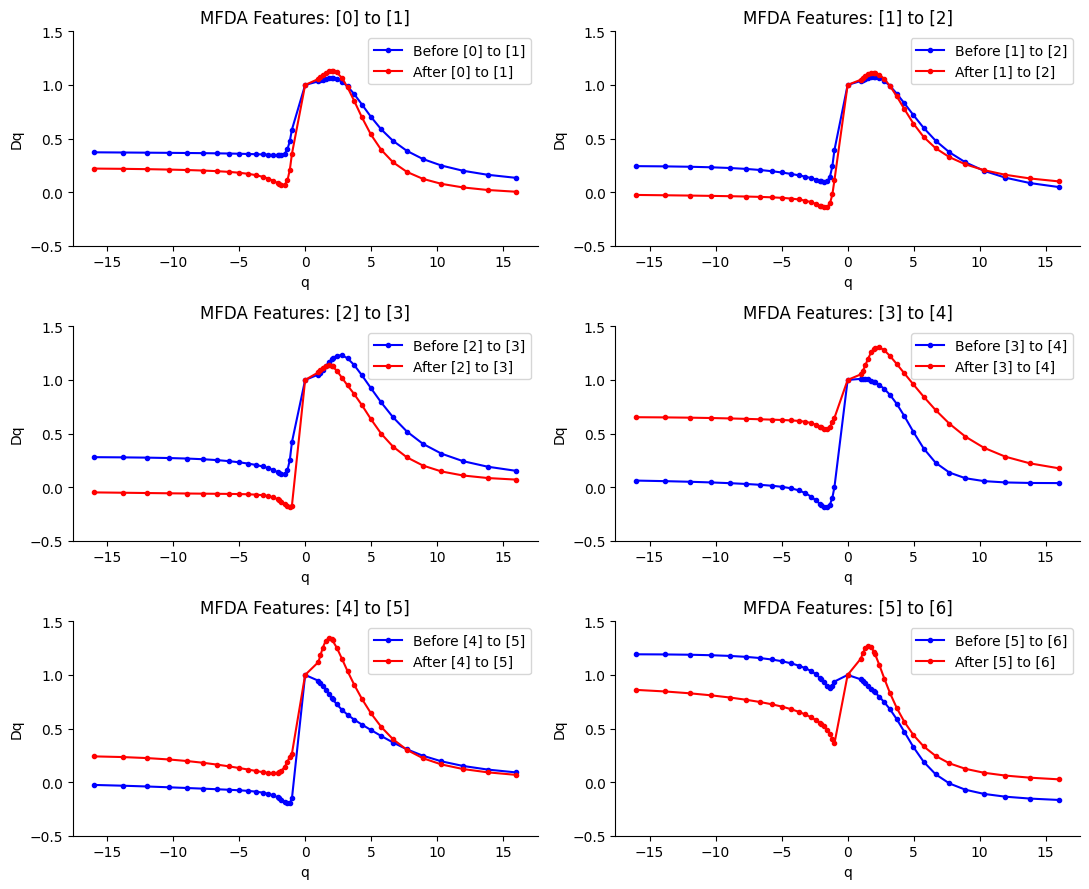

In [9]:
list(transition_features['avg_mfda_before_windows'].keys())

['[0] to [1]',
 '[1] to [2]',
 '[2] to [3]',
 '[3] to [4]',
 '[4] to [5]',
 '[5] to [6]']